In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
plt.style.use("ggplot")

In [3]:
def read_csv_file(file):
    df = pd.read_csv(file)
    return df

In [4]:
main_data = read_csv_file('covid_train.csv')
display(main_data.head())
print(main_data.shape)

,country_name,country_code,pop_total,pop_density,GDP,basic_water,safe_water,basic_san,safe_san,C1_School closing_1,...,transit,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,prev_cases,total_cases,new_cases_percentages
0,Kyrgyzstan,KGZ,6456900,32.965589,5470.811536,87.455903,68.223320,96.507067,NaN,0,...,NaN,-14.000000,-5.000000,11.000000,-13.666667,-10.666667,-2.666667,2789,3151,2
1,Italy,ITA,60297396,205.418372,44196.693100,99.442734,95.039615,98.772433,96.208014,0,...,59.42,-13.000000,-6.666667,57.000000,-28.666667,-27.666667,4.666667,238833,239706,1
2,Canada,CAN,37589262,4.075188,51341.705170,99.436244,98.860854,99.286013,82.316398,0,...,60.08,-8.666667,2.333333,169.666667,-31.666667,-18.333333,2.333333,130493,131495,2
3,Bolivia,BOL,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271,0,...,NaN,-63.666667,-48.666667,-55.666667,-64.333333,-49.666667,28.333333,42984,45565,3
4,Austria,AUT,8877067,107.127967,59110.562560,100.000000,98.906201,99.972910,96.746738,0,...,NaN,2.000000,-1.666667,112.333333,-20.666667,-34.666667,3.000000,23373,23875,2


(3864, 92)


# Country data

In [5]:
def read_country_data(df):
    new_df = df.loc[:,'country_name':'safe_san']
    return new_df

def read_conutry_numeric_data(df):
    new_df = df.loc[:,'pop_total':'safe_san']
    return new_df

country_data = read_country_data(main_data)

In [6]:
def drop_duplicate(df):
    new_df = df[~df.duplicated()]
    return new_df

unique_country_data = drop_duplicate(country_data)
unique_country_numeric_data = read_conutry_numeric_data(unique_country_data)
unique_country_numeric_data

,pop_total,pop_density,GDP,basic_water,safe_water,basic_san,safe_san
0,6456900,32.965589,5470.811536,87.455903,68.223320,96.507067,NaN
1,60297396,205.418372,44196.693100,99.442734,95.039615,98.772433,96.208014
2,37589262,4.075188,51341.705170,99.436244,98.860854,99.286013,82.316398
3,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271
4,8877067,107.127967,59110.562560,100.000000,98.906201,99.972910,96.746738
...,...,...,...,...,...,...,...
322,39309783,88.530570,11332.141470,96.533478,58.833327,94.121022,41.067753
377,126264931,347.073458,43235.717570,99.010208,98.453707,99.894708,98.760358
486,20321378,72.191283,2280.380037,47.888127,NaN,19.402087,NaN
683,16296364,82.347478,3535.568779,80.677854,NaN,51.473990,21.455765


## 1a. data preprocessing

In [7]:
def imputer(df):
    imp = IterativeImputer(random_state = 0)
    imputed_data = imp.fit_transform(df)
    return imputed_data

def standardize(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data

def to_dataframe(numeric_data):
    df = pd.DataFrame(numeric_data)
    return df
imputed_data = imputer(unique_country_numeric_data)
scaled_imputed_data = standardize(imputed_data)
scaled_imputed_df = to_dataframe(scaled_imputed_data)

In [8]:
def drop_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    index = ~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR))).any(axis=1)
    new_df = df[index]
    return new_df, index

processed_country_data, index = drop_outlier(scaled_imputed_df)
processed_country_data = processed_country_data.reset_index(drop = True)
unique_country_data = unique_country_data.reset_index(drop = True)[index]
unique_country_data

,country_name,country_code,pop_total,pop_density,GDP,basic_water,safe_water,basic_san,safe_san
0,Kyrgyzstan,KGZ,6456900,32.965589,5470.811536,87.455903,68.223320,96.507067,NaN
1,Italy,ITA,60297396,205.418372,44196.693100,99.442734,95.039615,98.772433,96.208014
2,Canada,CAN,37589262,4.075188,51341.705170,99.436244,98.860854,99.286013,82.316398
3,Bolivia,BOL,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271
4,Austria,AUT,8877067,107.127967,59110.562560,100.000000,98.906201,99.972910,96.746738
...,...,...,...,...,...,...,...,...,...
100,Denmark,DNK,5818553,137.976566,59830.154240,99.999999,96.734672,99.597229,94.840348
101,Nepal,NPL,28608710,195.939107,3558.399828,88.812250,27.243353,62.053595,NaN
102,Iraq,IRQ,39309783,88.530570,11332.141470,96.533478,58.833327,94.121022,41.067753
105,Senegal,SEN,16296364,82.347478,3535.568779,80.677854,NaN,51.473990,21.455765


## 1b. Hierarchical clustering

In [9]:
# Plots dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
# Plots scatter diagram
def clustering_scatter_plot(X, linkage, transform=True):
    if transform:
        transform_data = TSNE(n_components = 2, random_state = 10).fit_transform(X)
    else:
        transform_data = X
    ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage=linkage)
    link_pred = ac.fit_predict(X)
    labels = ['Cluster1', 'Cluster2','Cluster3']
    colours = ['orange','red', 'blue']
    for i in range(0,3):
        plt.scatter(transform_data[:,0][link_pred==i],
                    transform_data[:,1][link_pred==i],
                    c = colours[i], 
                    label = labels[i])
    plt.legend()
    plt.title("scatter plot with " + linkage + "-link distance")
    plt.show()
    print('For ' + linkage + '-link distance:\n')
    for i in range(3):
        print("Number of elements in cluster", i, "is", link_pred.tolist().count(i))
    return link_pred

## (i) Single-link distance

In [10]:
# Format the data to be fit 
X = np.array(processed_country_data)

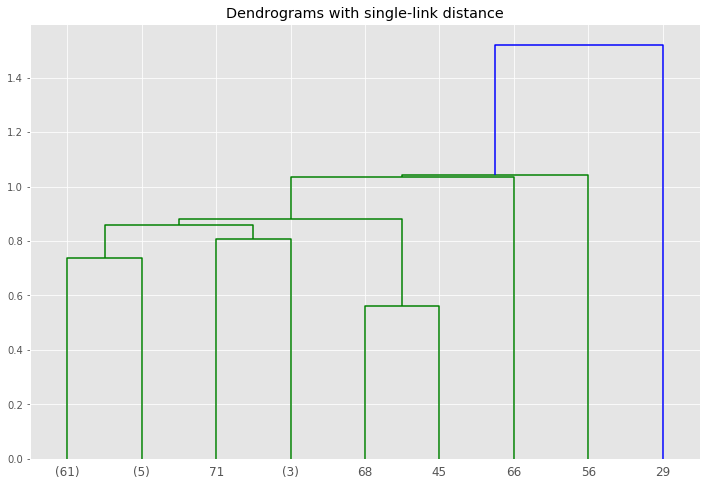

In [11]:
plt.figure(figsize=(12,8))
plt.title('Dendrograms with single-link distance')
ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
ac.fit(X)
plot_dendrogram(ac, truncate_mode='level', p=5)
plt.show()

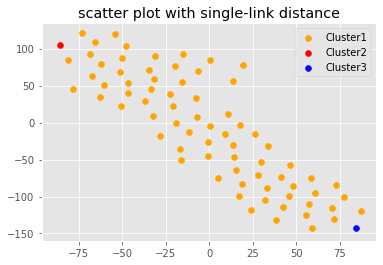

For single-link distance:

Number of elements in cluster 0 is 73
Number of elements in cluster 1 is 1
Number of elements in cluster 2 is 1


In [12]:
single_link_pred = clustering_scatter_plot(X, 'single')

## (ii) complete-link distance

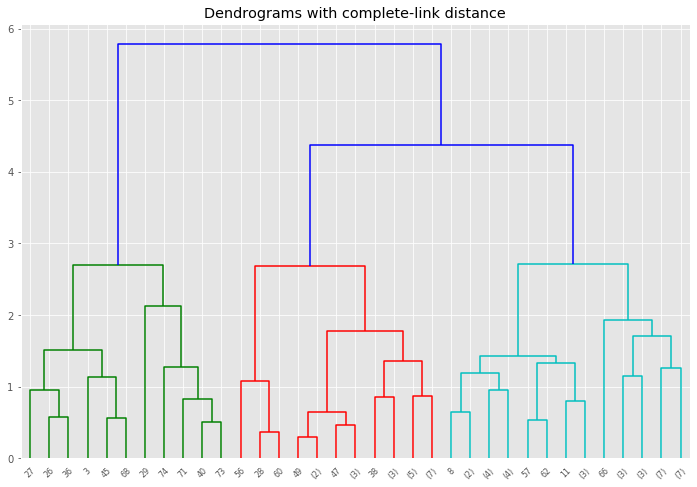

In [13]:
plt.figure(figsize=(12,8))
plt.title('Dendrograms with complete-link distance')
ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
ac.fit(X)
plot_dendrogram(ac, truncate_mode='level', p=5)
plt.show()

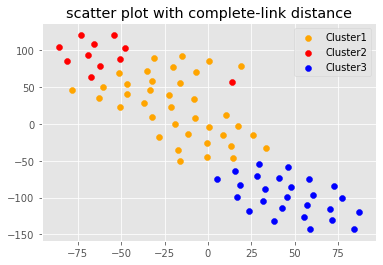

For complete-link distance:

Number of elements in cluster 0 is 38
Number of elements in cluster 1 is 11
Number of elements in cluster 2 is 26


In [14]:
complete_link_pred = clustering_scatter_plot(X, 'complete')

## (iii) Average-link distance

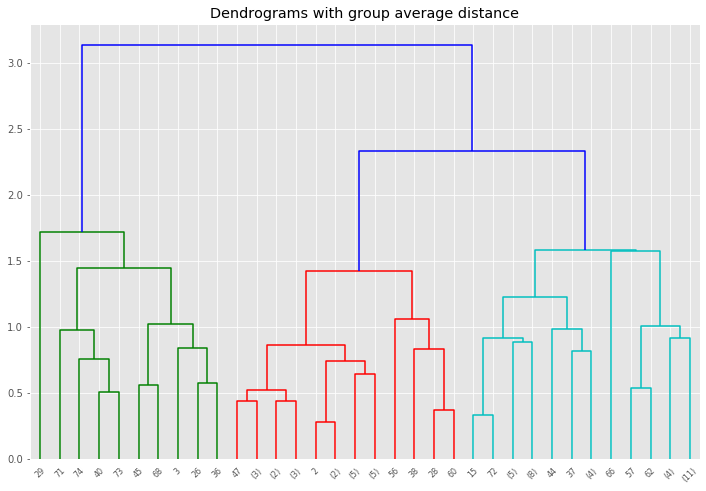

In [15]:
plt.figure(figsize=(12,8))
plt.title('Dendrograms with group average distance')
ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
ac.fit(X)
plot_dendrogram(ac, truncate_mode='level', p=5)
plt.show()

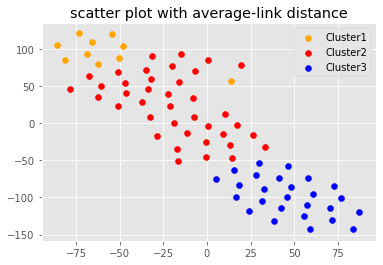

For average-link distance:

Number of elements in cluster 0 is 10
Number of elements in cluster 1 is 39
Number of elements in cluster 2 is 26


In [16]:
average_link_pred = clustering_scatter_plot(X, 'average')

# 1c. Clustering Validity Measures

In [17]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [18]:
dbs_single_link = davies_bouldin_score(X, single_link_pred)
dbs_complete_link = davies_bouldin_score(X, complete_link_pred)
dbs_average_link = davies_bouldin_score(X, average_link_pred)

print("Davies–Bouldin Score Result:"
      +'\nsingle-link: '+str(dbs_single_link)
      +'\ncomplete-link: '+str(dbs_complete_link)
      +'\naverage-link: '+str(dbs_average_link))

Davies–Bouldin Score Result:
single-link: 0.5137742665128471
complete-link: 0.819269481106398
average-link: 0.7733178860340705


In [19]:
ss_single_link = silhouette_score(X, single_link_pred)
ss_complete_link = silhouette_score(X, complete_link_pred)
ss_average_link = silhouette_score(X, average_link_pred)

print("Silhouette Score Result:"
      +'\nsingle-link: '+str(ss_single_link)
      +'\ncomplete-link: '+str(ss_complete_link)
      +'\naverage-link: '+str(ss_average_link))

Silhouette Score Result:
single-link: 0.1020194433430128
complete-link: 0.41386704795264717
average-link: 0.42968049502721345


Although the score for single linkage is good for the Davies-Bouldin score, the measure favors imbalanced clustering, which is reflected in the Silhouette score. Therefore, single linkage is not good here. Between complete linkage and group average linkage, we can see that group average linkage has a slight advantage for both scores, so it is the best out of the three distance measures for this dataset.

# 1d. Visualization

In [20]:
unique_country_data['group'] = average_link_pred
country_cluster = []
for i in range(3):
    custer_i = unique_country_data[unique_country_data['group'] == i]
    country_cluster.append(custer_i)

In [21]:
for i in range(3):
    print('For custer '+str(i)+':\n')
    custer_i = country_cluster[i].country_name.to_numpy()
    print(custer_i)
    print('Total = '+str(len(custer_i)))
    print('\n')

For custer 0:

['Bolivia' 'Guatemala' "Lao People's Democratic Republic" 'Peru'
 'Cambodia' 'Myanmar' 'Nicaragua' 'Nepal' 'Senegal' 'Mali']
Total = 10


For custer 1:

['Kyrgyzstan' 'Ukraine' 'Libyan Arab Jamahiriya' 'Dominican Republic'
 'Egypt' 'Oman' 'Costa Rica' 'Colombia' 'Uzbekistan' 'Morocco'
 'South Africa' 'El Salvador' 'Vietnam' 'Azerbaijan' 'Algeria'
 'Moldova, Republic of' 'Paraguay' 'Thailand' 'Bosnia and Herzegovina'
 'Ecuador' 'Jordan' 'Venezuela' 'Sri Lanka' 'Serbia' 'Albania' 'Tunisia'
 'Croatia' 'Turkey' 'Honduras' 'Panama' 'Uruguay' 'Kazakhstan' 'Romania'
 'Bulgaria' 'Chile' 'Puerto Rico' 'Argentina' 'Belarus' 'Iraq']
Total = 39


For custer 2:

['Italy' 'Canada' 'Austria' 'Czech Republic' 'Malaysia' 'New Zealand'
 'United Kingdom' 'Slovakia' 'Kuwait' 'Poland' 'Switzerland' 'Greece'
 'Finland' 'Portugal' 'Sweden' 'Norway' 'Germany' 'Hungary' 'Slovenia'
 'Saudi Arabia' 'Australia' 'Ireland' 'France' 'United Arab Emirates'
 'Spain' 'Denmark']
Total = 26




In [22]:
for i in range(3):
    print('For custer '+str(i)+':\n')
    print(country_cluster[i].describe())
    print('\n')

For custer 0:

          pop_total  pop_density           GDP  basic_water  safe_water  \
count  1.000000e+01    10.000000     10.000000    10.000000    6.000000   
mean   2.094376e+07    74.055834   6468.767884    84.978949   37.852119   
std    1.428360e+07    61.137676   3379.900334     6.105321   16.762400   
min    6.545502e+06    10.480146   2423.828765    78.260830   16.081866   
25%    1.270892e+07    26.392651   3811.473443    80.889581   26.195000   
50%    1.654528e+07    67.982832   5493.235881    81.917973   38.797002   
75%    2.637104e+07    89.629179   8784.341511    90.548966   51.288046   
max    5.404542e+07   195.939107  13380.364420    94.190581   55.990782   

       basic_san   safe_san  group  
count  10.000000   5.000000   10.0  
mean   62.543983  32.784351    0.0  
std    11.095004  17.040602    0.0  
min    39.335420  18.709404    0.0  
25%    59.599459  21.455765    0.0  
50%    63.193140  22.938271    0.0  
75%    72.023001  42.764723    0.0  
max    74.459

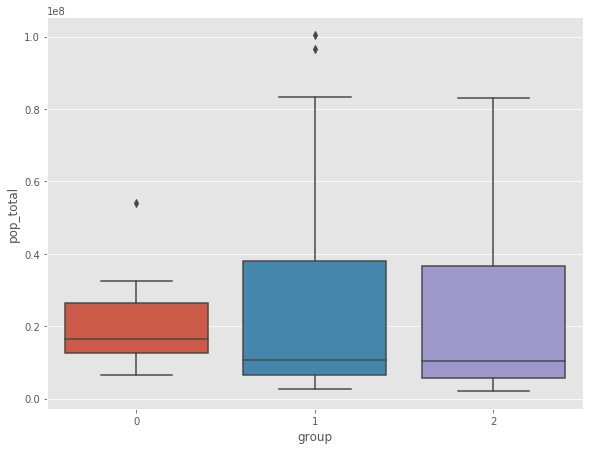

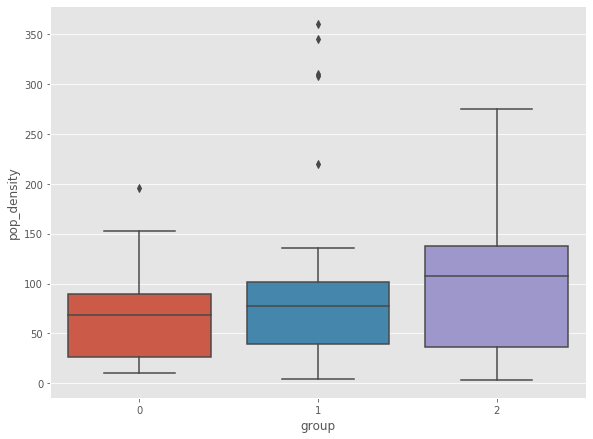

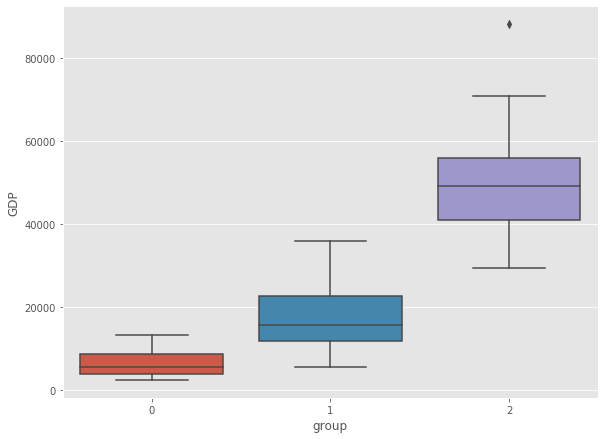

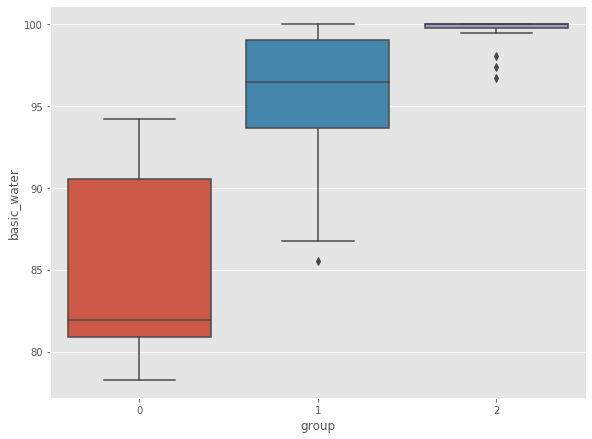

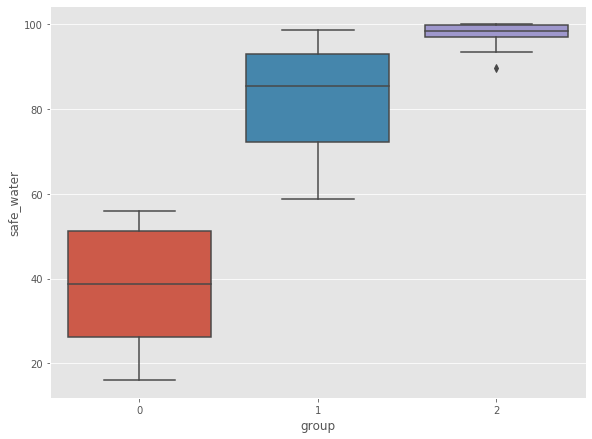

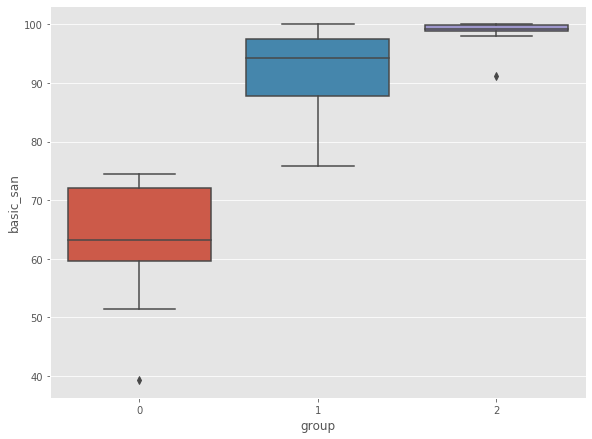

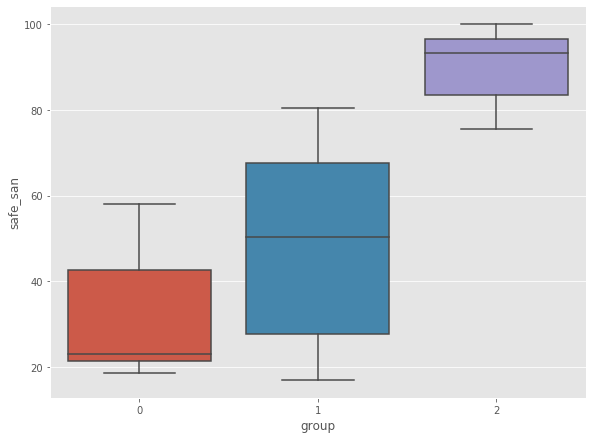

In [23]:
for i in unique_country_data.columns[2:-1]:
    fig, ax = plt.subplots(figsize=(9.6, 7.2))
    sns.boxplot(x=unique_country_data['group'], y=unique_country_data[i])
plt.show()

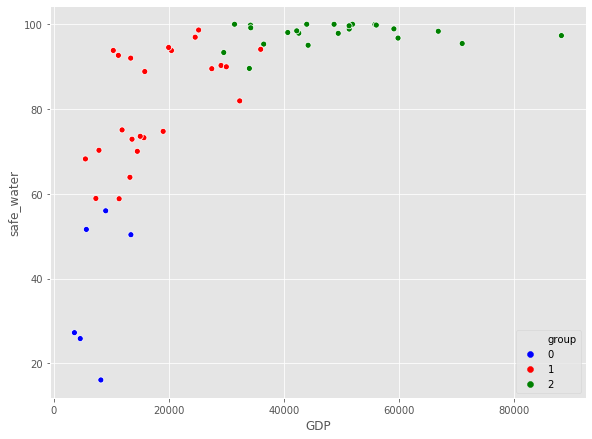

In [123]:
colour = ['blue','red','green']
fig, ax = plt.subplots(figsize=(9.6, 7.2))
sns.scatterplot(data = unique_country_data, x = 'GDP', y = 'safe_water', hue = 'group', palette = colour)
plt.show()

# Apriori By Country Group

### Group 1

In [25]:
group_1 = main_data[main_data['country_name'].isin(unique_country_data[unique_country_data['group']==0]['country_name'])]
group_1

,country_name,country_code,pop_total,pop_density,GDP,basic_water,safe_water,basic_san,safe_san,C1_School closing_1,...,transit,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,prev_cases,total_cases,new_cases_percentages
3,Bolivia,BOL,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271,0,...,NaN,-63.666667,-48.666667,-55.666667,-64.333333,-49.666667,28.333333,42984,45565,3
20,Bolivia,BOL,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271,0,...,NaN,-52.000000,-37.333333,-45.333333,-54.000000,-30.333333,18.666667,117928,120241,3
40,Guatemala,GTM,16604026,152.547126,8995.537873,94.190581,55.990782,65.063135,NaN,0,...,NaN,-47.000000,-32.333333,-41.000000,-62.333333,-39.666667,22.666667,7502,8221,2
48,Lao People's Democratic Republic,LAO,7169455,30.595784,8150.752426,82.061897,16.081866,74.459410,58.053590,0,...,NaN,-6.666667,1.000000,-5.333333,-19.333333,0.000000,2.333333,19,19,0
60,Peru,PER,32510453,24.991606,13380.364420,91.127871,50.350652,74.342957,42.764723,0,...,NaN,-76.333333,-54.333333,-58.333333,-69.000000,-56.333333,28.333333,251338,254936,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,Bolivia,BOL,11513100,10.480146,9086.060696,92.848735,NaN,60.716938,22.938271,0,...,NaN,-62.333333,-47.000000,-52.000000,-61.666667,-48.333333,27.666667,32125,34227,3
3832,Senegal,SEN,16296364,82.347478,3535.568779,80.677854,NaN,51.473990,21.455765,0,...,NaN,-36.000000,-13.000000,-27.000000,-41.666667,-28.333333,16.666667,2714,2909,1
3835,Guatemala,GTM,16604026,152.547126,8995.537873,94.190581,55.990782,65.063135,NaN,0,...,NaN,-47.333333,-34.000000,-39.666667,-63.000000,-40.333333,22.666667,703,763,0
3836,Senegal,SEN,16296364,82.347478,3535.568779,80.677854,NaN,51.473990,21.455765,0,...,NaN,-25.333333,-14.333333,-19.333333,-37.333333,-14.333333,11.333333,4021,4427,2


In [26]:
columns = list(group_1.columns[9:47])
columns.append(group_1.columns[-1])
group_1 = group_1[columns]
group_1['minimum_50'] = 0
group_1.loc[((group_1['new_cases_percentages'] == 0) | (group_1['new_cases_percentages'] == 1)), 'minimum_50'] = 1
group_1 = group_1.drop('new_cases_percentages', axis=1)
group_1

/Users/stephentang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/stephentang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/stephentang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

,C1_School closing_1,C1_School closing_2,C1_School closing_3,C2_Workplace closing_1,C2_Workplace closing_2,C2_Workplace closing_3,C3_Cancel public events_1,C3_Cancel public events_2,C4_Restrictions on gatherings_1,C4_Restrictions on gatherings_2,...,H2_Testing policy_1,H2_Testing policy_2,H2_Testing policy_3,H3_Contact tracing_1,H3_Contact tracing_2,H6_Facial Coverings_1,H6_Facial Coverings_2,H6_Facial Coverings_3,H6_Facial Coverings_4,minimum_50
3,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
20,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
40,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
48,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
60,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3832,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
3835,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
3836,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0


In [27]:
frequent_items = apriori(group_1, use_colnames=True, min_support=0.2, max_len=None, verbose=1)

Processing 121 combinations | Sampling itemset size 110


In [28]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.6)

In [29]:
results = rules[(rules['consequents'] == {'minimum_50'})].sort_values(by=['lift'], ascending=False)
results.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
703,"(H3_Contact tracing_1, C2_Workplace closing_2)",(minimum_50),0.351792,0.550489,0.228013,0.648148,1.177405,0.034356,1.277559
4912,"(H1_Public information campaigns_2, H3_Contact...",(minimum_50),0.351792,0.550489,0.228013,0.648148,1.177405,0.034356,1.277559
142,(H3_Contact tracing_1),(minimum_50),0.397394,0.550489,0.250814,0.631148,1.146522,0.032053,1.218675
1539,"(H1_Public information campaigns_2, H3_Contact...",(minimum_50),0.397394,0.550489,0.250814,0.631148,1.146522,0.032053,1.218675
141,(H2_Testing policy_1),(minimum_50),0.573290,0.550489,0.358306,0.625000,1.135355,0.042717,1.198697


In [30]:
policies = {}
for i in results['antecedents']:
    for j in i:
        if j not in policies: 
            policies[j] = 0
        policies[j] += 1

([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

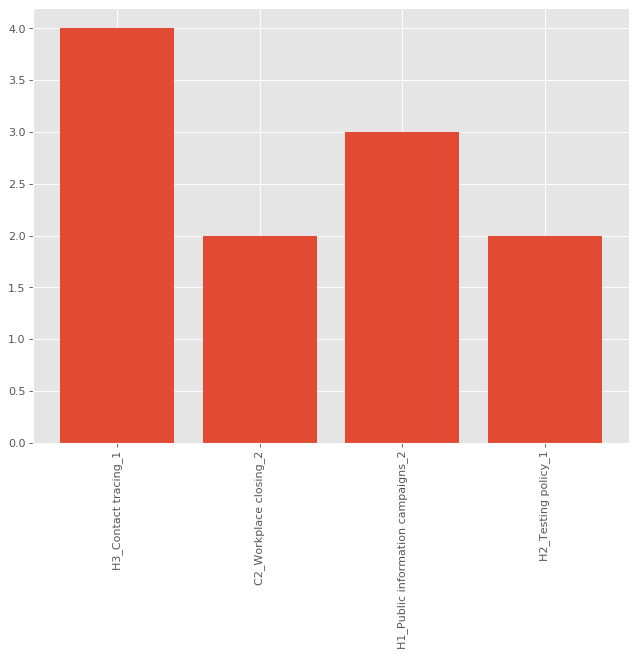

In [31]:
plt.figure(figsize=(9.6, 7.2), dpi=80)
plt.bar(policies.keys(), policies.values())
plt.xticks(rotation=90)

### Group 2

In [32]:
group_2 = main_data[main_data['country_name'].isin(unique_country_data[unique_country_data['group']==1]['country_name'])]
columns = list(group_2.columns[9:47])
columns.append(group_2.columns[-1])
group_2 = group_2[columns]
group_2['minimum_50'] = 0
group_2.loc[((group_2['new_cases_percentages'] == 0) | (group_2['new_cases_percentages'] == 1)), 'minimum_50'] = 1
group_2 = group_2.drop('new_cases_percentages', axis=1)

In [33]:
frequent_items = apriori(group_2, use_colnames=True, min_support=0.2, max_len=None, verbose=1)

Processing 2484 combinations | Sampling itemset size 6


In [34]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.6)

In [35]:
results = rules[(rules['consequents'] == {'minimum_50'})].sort_values(by=['lift'], ascending=False)
results.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


### Group 3

In [36]:
group_3 = main_data[main_data['country_name'].isin(unique_country_data[unique_country_data['group'] == 2]['country_name'])]
columns = list(group_3.columns[9:47])
columns.append(group_3.columns[-1])
group_3 = group_3[columns]
group_3['minimum_50'] = 0
group_3.loc[((group_3['new_cases_percentages'] == 0) | (group_3['new_cases_percentages'] == 1)), 'minimum_50'] = 1
group_3 = group_3.drop('new_cases_percentages', axis = 1)
group_3

,C1_School closing_1,C1_School closing_2,C1_School closing_3,C2_Workplace closing_1,C2_Workplace closing_2,C2_Workplace closing_3,C3_Cancel public events_1,C3_Cancel public events_2,C4_Restrictions on gatherings_1,C4_Restrictions on gatherings_2,...,H2_Testing policy_1,H2_Testing policy_2,H2_Testing policy_3,H3_Contact tracing_1,H3_Contact tracing_2,H6_Facial Coverings_1,H6_Facial Coverings_2,H6_Facial Coverings_3,H6_Facial Coverings_4,minimum_50
1,0,0,1,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,1
2,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,1,0,0,0
5,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,1
6,0,0,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,1
3850,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1
3854,1,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3856,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [37]:
frequent_items = apriori(group_3, use_colnames=True, min_support=0.2, max_len=None, verbose=1)

Processing 365 combinations | Sampling itemset size 5


In [38]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.6)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(C1_School closing_2),(C2_Workplace closing_2),0.325203,0.489837,0.211382,0.650000,1.326971,0.052085,1.457607
1,(C1_School closing_2),(C8_International travel controls_3),0.325203,0.553862,0.205285,0.631250,1.139725,0.025167,1.209866
2,(C1_School closing_2),(E1_Income support_2),0.325203,0.686992,0.203252,0.625000,0.909763,-0.020160,0.834688
3,(C1_School closing_2),(E2_Debt/contract relief_2),0.325203,0.521341,0.213415,0.656250,1.258772,0.043873,1.392461
4,(C1_School closing_2),(H1_Public information campaigns_2),0.325203,0.998984,0.324187,0.996875,0.997889,-0.000686,0.325203
...,...,...,...,...,...,...,...,...,...
587,"(H3_Contact tracing_2, H1_Public information c...",(minimum_50),0.365854,0.541667,0.224593,0.613889,1.133333,0.026423,1.187050
588,"(H3_Contact tracing_2, minimum_50, H2_Testing ...",(H1_Public information campaigns_2),0.224593,0.998984,0.224593,1.000000,1.001017,0.000228,inf
589,"(H1_Public information campaigns_2, minimum_50...",(H3_Contact tracing_2),0.271341,0.730691,0.224593,0.827715,1.132784,0.026327,1.563163
590,"(H3_Contact tracing_2, H2_Testing policy_2)","(H1_Public information campaigns_2, minimum_50)",0.365854,0.541667,0.224593,0.613889,1.133333,0.026423,1.187050


In [39]:
results = rules[(rules['consequents'] == {'minimum_50'})].sort_values(by=['lift'], ascending=False)
results.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
364,"(E2_Debt/contract relief_2, H3_Contact tracing_2)",(minimum_50),0.410569,0.541667,0.285569,0.695545,1.284082,0.063178,1.505420
580,"(E2_Debt/contract relief_2, H3_Contact tracing...",(minimum_50),0.410569,0.541667,0.285569,0.695545,1.284082,0.063178,1.505420
553,"(E2_Debt/contract relief_2, H1_Public informat...",(minimum_50),0.341463,0.541667,0.225610,0.660714,1.219780,0.040650,1.350877
322,"(E2_Debt/contract relief_2, E1_Income support_2)",(minimum_50),0.341463,0.541667,0.225610,0.660714,1.219780,0.040650,1.350877
544,"(H3_Contact tracing_2, H1_Public information c...",(minimum_50),0.394309,0.541667,0.259146,0.657216,1.213323,0.045562,1.337093


In [40]:
policies = {}
for i in results['antecedents']:
    for j in i:
        if j not in policies: 
            policies[j] = 0
        policies[j] += 1

In [41]:
policies

{'E2_Debt/contract relief_2': 8,
 'H3_Contact tracing_2': 8,
 'H1_Public information campaigns_2': 10,
 'E1_Income support_2': 4,
 'C8_International travel controls_3': 4,
 'C1_School closing_2': 2,
 'C3_Cancel public events_2': 4,
 'H6_Facial Coverings_2': 2,
 'H2_Testing policy_2': 2}

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

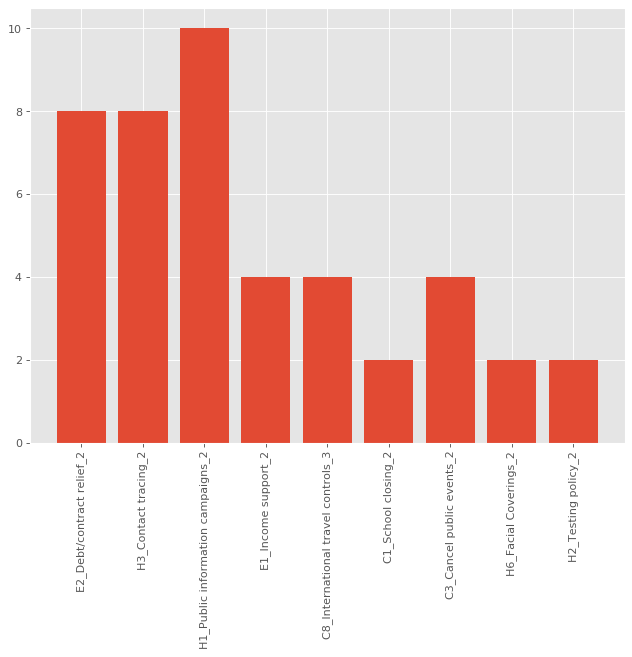

In [42]:
plt.figure(figsize=(9.6, 7.2), dpi=80)
plt.bar(policies.keys(), policies.values())
plt.xticks(rotation=90)

# Symptoms Analysis

In [43]:
main_data['total_cases_percentages'] = (main_data['total_cases']/main_data['pop_total'])*100
print(main_data['total_cases_percentages'])
print(f'median: {main_data["total_cases_percentages"].median()}')

0       0.048801
1       0.397540
2       0.349821
3       0.395767
4       0.268951
          ...   
3859    0.675730
3860    0.004619
3861    0.021407
3862    0.053016
3863    0.179462
Name: total_cases_percentages, Length: 3864, dtype: float64
median: 0.09900189316419707


In [44]:
symptoms = main_data.iloc[:,51:64]
for (columnName, columnData) in symptoms.iteritems():
    symptoms[columnName] = pd.qcut(main_data[columnName], q=2, labels=[0, 1])
symptoms['total_cases_percentages'] = pd.qcut(main_data['total_cases_percentages'], q=2, labels=[0, 1])

In [45]:
symptoms

,pct_fever_weighted,pct_cough_weighted,pct_difficulty_breathing_weighted,pct_fatigue_weighted,pct_stuffy_runny_nose_weighted,pct_aches_muscle_pain_weighted,pct_sore_throat_weighted,pct_chest_pain_weighted,pct_nausea_weighted,pct_anosmia_ageusia_weighted,pct_eye_pain_weighted,pct_headache_weighted,pct_chills_weighted,total_cases_percentages
0,1,0,0,1,1,1,1,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859,1,1,1,1,1,0,1,1,1,1,0,1,1,1
3860,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3861,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3862,0,0,0,0,0,0,1,0,1,0,1,1,0,0


In [46]:
frequent_items = apriori(symptoms, use_colnames=True, min_support=0.2, max_len=None, verbose=1)

Processing 108 combinations | Sampling itemset size 97


In [47]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.6)

In [48]:
results = rules[(rules['consequents'] == {'total_cases_percentages'})].sort_values(by=['lift'], ascending=False)
results.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2921,"(pct_cough_weighted, pct_stuffy_runny_nose_wei...",(total_cases_percentages),0.307195,0.5,0.220238,0.716933,1.433867,0.066641,1.766369
625,"(pct_stuffy_runny_nose_weighted, pct_difficult...",(total_cases_percentages),0.355331,0.5,0.247930,0.697742,1.395484,0.070264,1.654217
3268,"(pct_cough_weighted, pct_aches_muscle_pain_wei...",(total_cases_percentages),0.289337,0.5,0.201605,0.696780,1.393560,0.056936,1.648968
3333,"(pct_cough_weighted, pct_stuffy_runny_nose_wei...",(total_cases_percentages),0.297101,0.5,0.205745,0.692509,1.385017,0.057195,1.626062
816,"(pct_stuffy_runny_nose_weighted, pct_aches_mus...",(total_cases_percentages),0.336698,0.5,0.231625,0.687932,1.375865,0.063276,1.602217


In [49]:
symptoms = {}
for i in results['antecedents']:
    for j in i:
        if j not in symptoms: 
            symptoms[j] = 0
        symptoms[j] += 1

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

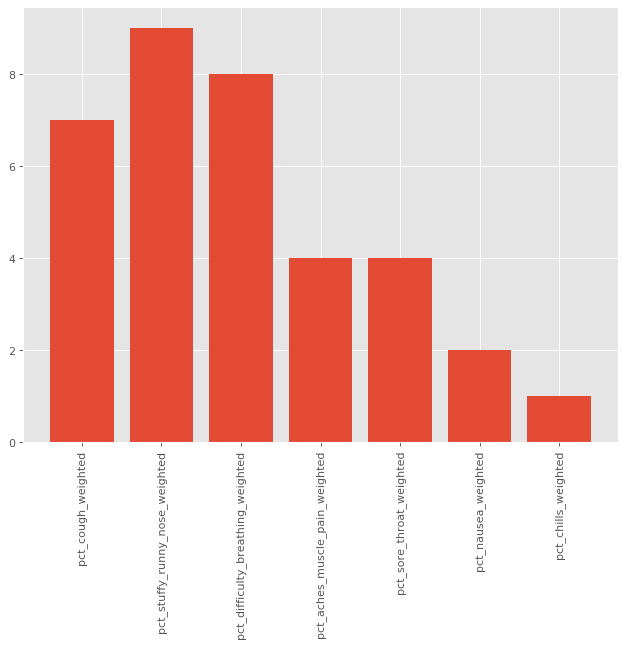

In [50]:
plt.figure(figsize=(9.6, 7.2), dpi=80)
plt.bar(symptoms.keys(), symptoms.values())
plt.xticks(rotation=90)

# Mobility Data

In [51]:
mobility = main_data.iloc[:,80:89]
log_pop_density = np.log(main_data['pop_density'])

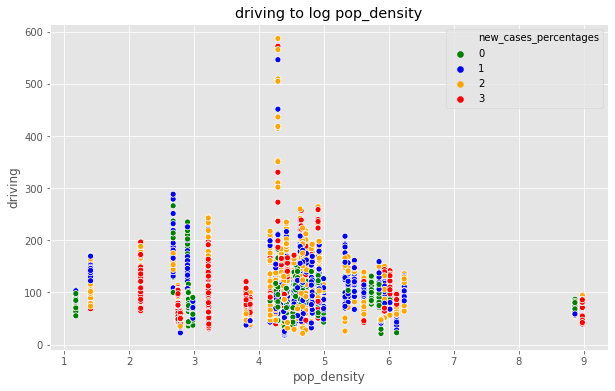

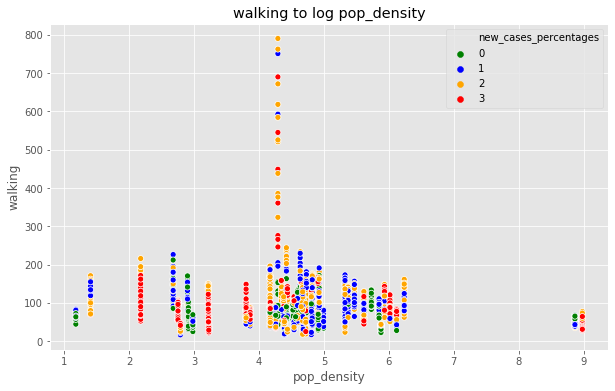

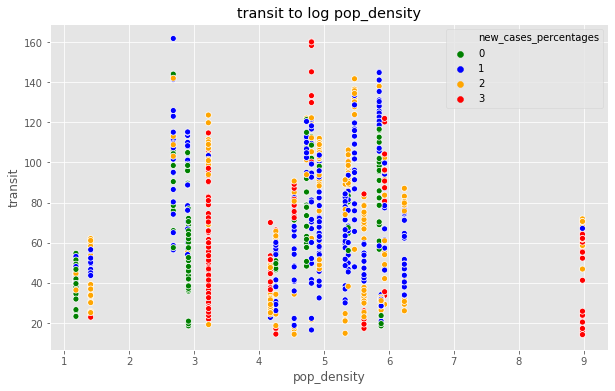

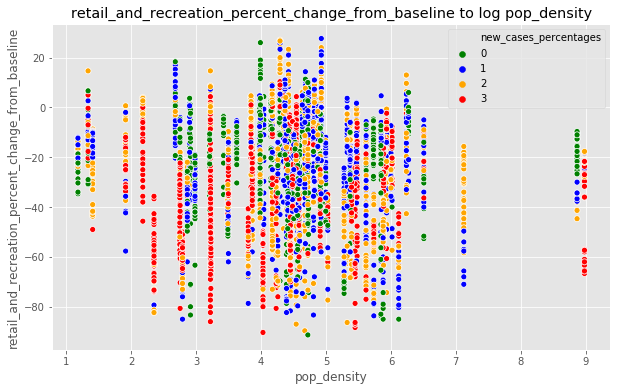

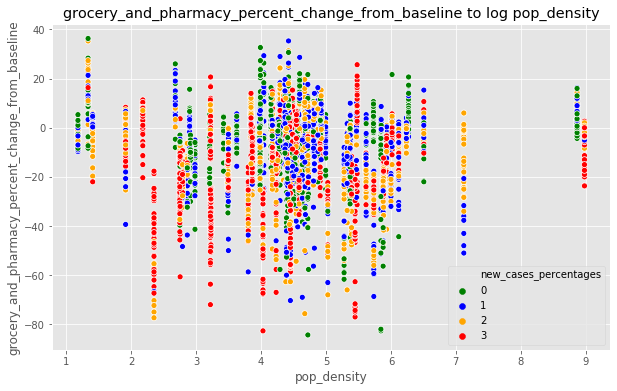

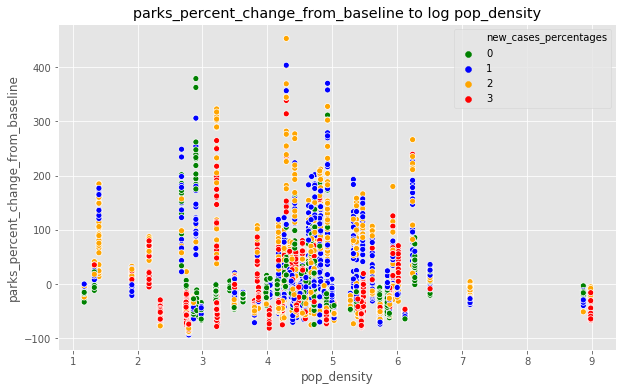

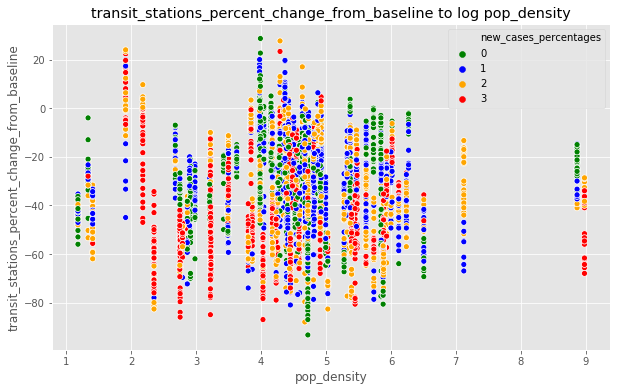

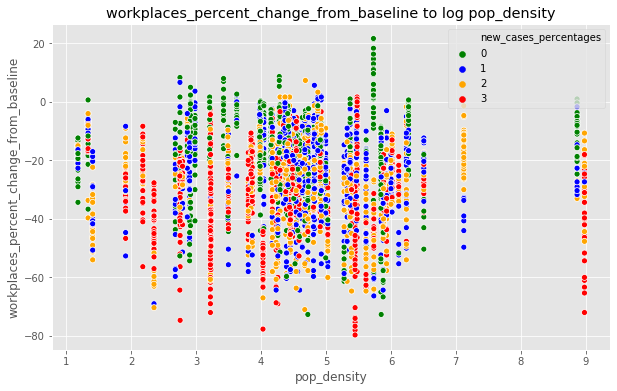

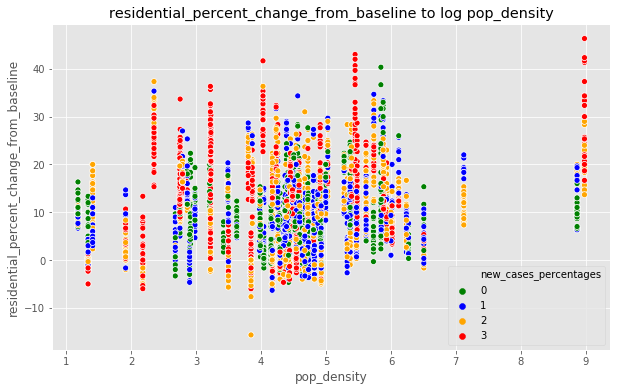

In [52]:
colour = {0:'green', 1:'blue', 2:'orange', 3:'red'}
for col in mobility.columns:
    plt.figure(figsize = (10,6))
    sns.scatterplot(x = log_pop_density, y = mobility[col], hue = main_data.new_cases_percentages, 
                    palette = colour, legend = 'brief')
    plt.legend(loc = 'best')
    plt.title(col + ' to log pop_density')
    plt.plot()

In [53]:
# Add pop_density and new_cases_percentage to mobility_data
pop_density_data = main_data['pop_density']
new_cases_percentages = main_data['new_cases_percentages']
mobility = pd.concat([mobility,new_cases_percentages, pop_density_data],axis = 1)
# Create division by percentile
mobility['group'] = pd.qcut(mobility['pop_density'], q = 5, labels = [0, 1, 2, 3, 4])
mobility.head()

,driving,walking,transit,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new_cases_percentages,pop_density,group
0,NaN,NaN,NaN,-14.000000,-5.000000,11.000000,-13.666667,-10.666667,-2.666667,2,32.965589,1
1,130.283333,84.92,59.42,-13.000000,-6.666667,57.000000,-28.666667,-27.666667,4.666667,1,205.418372,3
2,164.786667,171.06,60.08,-8.666667,2.333333,169.666667,-31.666667,-18.333333,2.333333,2,4.075188,0
3,NaN,NaN,NaN,-63.666667,-48.666667,-55.666667,-64.333333,-49.666667,28.333333,3,10.480146,0
4,168.476667,146.01,NaN,2.000000,-1.666667,112.333333,-20.666667,-34.666667,3.000000,2,107.127967,2


In [54]:
# Split each division into group
different_group = []
for i in range(5):
    different_group.append(mobility[mobility['group'] == i])
# Print the most correlated attributes
for i in range(5):
    print(f'For group {i}:')
    correlation = different_group[i].loc[:,'driving':'new_cases_percentages'].corr()
    display(correlation['new_cases_percentages'].abs().sort_values(ascending = False)[:6])
    print('\n')

For group 0:


new_cases_percentages                                 1.000000
workplaces_percent_change_from_baseline               0.426108
retail_and_recreation_percent_change_from_baseline    0.410053
grocery_and_pharmacy_percent_change_from_baseline     0.345408
residential_percent_change_from_baseline              0.333830
transit_stations_percent_change_from_baseline         0.228179
Name: new_cases_percentages, dtype: float64



For group 1:


new_cases_percentages                                 1.000000
workplaces_percent_change_from_baseline               0.455475
transit_stations_percent_change_from_baseline         0.360172
retail_and_recreation_percent_change_from_baseline    0.307178
grocery_and_pharmacy_percent_change_from_baseline     0.295492
residential_percent_change_from_baseline              0.261689
Name: new_cases_percentages, dtype: float64



For group 2:


new_cases_percentages                            1.000000
driving                                          0.347468
walking                                          0.282776
workplaces_percent_change_from_baseline          0.244669
transit                                          0.234568
transit_stations_percent_change_from_baseline    0.093276
Name: new_cases_percentages, dtype: float64



For group 3:


new_cases_percentages                                 1.000000
transit                                               0.292131
workplaces_percent_change_from_baseline               0.283891
residential_percent_change_from_baseline              0.268057
grocery_and_pharmacy_percent_change_from_baseline     0.257563
retail_and_recreation_percent_change_from_baseline    0.219401
Name: new_cases_percentages, dtype: float64



For group 4:


new_cases_percentages                                 1.000000
transit_stations_percent_change_from_baseline         0.359921
workplaces_percent_change_from_baseline               0.357643
residential_percent_change_from_baseline              0.292798
transit                                               0.277342
retail_and_recreation_percent_change_from_baseline    0.207211
Name: new_cases_percentages, dtype: float64

# Model

In [110]:
data = main_data.iloc[:,2:-3]
y = main_data[main_data.columns[-2]].values
X = standardize(imputer(data))

In [111]:
print(X.shape)

(3864, 88)


In [114]:
print(y.shape)

(3864,)


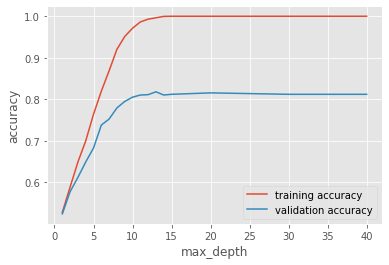

0.9204881656804734
0.7793103448275862


In [113]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 0)
training_accuracy = []
validation_accuracy = []
depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40]

for n in depth:
    forest = RandomForestClassifier(n_estimators = 1000, max_depth = n, random_state = 0, n_jobs = -1)
    forest.fit(X_train,y_train)
    training_accuracy.append(forest.score(X_train,y_train))
    validation_accuracy.append(forest.score(X_valid,y_valid))

plt.plot(depth,training_accuracy,label='training accuracy')
plt.plot(depth,validation_accuracy,label='validation accuracy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.legend()
plt.show()
print(training_accuracy[7])
print(validation_accuracy[7])

In [119]:
param_grid = {
     'n_estimators': [300, 500, 1000, 2000, 3000], 
     'max_depth': np.arange(5, 12, 2),
     'min_samples_split' : [2, 5, 10],
     'min_samples_leaf' : [1, 2, 4],
    }

forest = RandomForestClassifier(random_state = 10, n_jobs = -1)
forest_cv = GridSearchCV(forest, param_grid, cv = 3, verbose = True)
forest_cv.fit(X_train,y_train)
print(f'best paramter: {forest_cv.best_params_}')
print(f'score: {forest_cv.best_score_}')

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 31.4min finished


best paramter: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3000}
score: 0.7758862822207074


In [120]:
clf = RandomForestClassifier(bootstrap = False, criterion = 'entropy', max_depth = 11, max_features = 'auto',
                             min_samples_leaf = 1, min_samples_split = 2, n_estimators = 3000, n_jobs = -1)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_valid, y_valid))

0.9970414201183432
0.8189655172413793


In [121]:
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))

[[253  22   2   1]
 [ 35 225  31   0]
 [  8  52 220  35]
 [  0   1  23 252]]


In [122]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       278
           1       0.75      0.77      0.76       291
           2       0.80      0.70      0.74       315
           3       0.88      0.91      0.89       276

    accuracy                           0.82      1160
   macro avg       0.82      0.82      0.82      1160
weighted avg       0.82      0.82      0.82      1160

